# TUGAS2_KELOMPOK3 — Optimized Logistic (Binary) & Softmax (Multiclass)

Notebook ini merapikan pipeline agar **anti-leakage, reproducible, dan evaluasi lebih kuat**.

## Apa yang berubah
- Gunakan **Pipeline + ColumnTransformer** (imputasi + scaling + encoding) → mencegah data leakage.
- **Stratified split + Stratified K-Fold CV** untuk metrik yang stabil.
- **class_weight=\"balanced\"** pada logistic biner (atasi imbalance).
- **Threshold tuning** (biner) via Precision-Recall untuk F1 optimal.
- **Confusion matrix ter-normalisasi** dan **classification_report** per-kelas.

> **Cara pakai cepat:** Atur variabel pada *Config* (path & nama kolom target). Jika hanya punya salah satu target (biner atau multikelas), biarkan yang lain `None`.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproduktibilitas
np.random.seed(42)

print("="*80)
print("TUGAS 2: REGRESI LOGISTIK DAN REGRESI SOFTMAX")
print("="*80)

TUGAS 2: REGRESI LOGISTIK DAN REGRESI SOFTMAX


# BAGIAN I: PEMILIHAN DAN PRA-PEMROSESAN DATA

In [19]:
print("\n" + "="*80)
print("BAGIAN I: PEMILIHAN DAN PRA-PEMROSESAN DATA")
print("="*80)

# 1. Load Dataset
print("\n1. AKUISISI DATASET")
print("-" * 80)

# Definisikan nama kolom untuk wdbc.data karena file tidak punya header
column_names = [
    'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 
    'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 
    'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 
    'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 
    'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 
    'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 
    'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

# Ganti path file ini sesuai dengan lokasi file wdbc.data Anda
file_path = '/home/wgg/proyek-jupyter/Tugas PMA/breast+cancer+wisconsin+diagnostic/wdbc.data'
df = pd.read_csv(file_path, header=None, names=column_names)

# Buang kolom 'id' yang tidak diperlukan
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# Definisikan nama kolom target yang benar
target_column = 'diagnosis'

print(f"Dataset berhasil dimuat!")
print(f"Dimensi dataset: {df.shape[0]} baris × {df.shape[1]} kolom")
print(f"\nKolom-kolom dalam dataset:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")


BAGIAN I: PEMILIHAN DAN PRA-PEMROSESAN DATA

1. AKUISISI DATASET
--------------------------------------------------------------------------------
Dataset berhasil dimuat!
Dimensi dataset: 569 baris × 31 kolom

Kolom-kolom dalam dataset:
  1. diagnosis
  2. radius_mean
  3. texture_mean
  4. perimeter_mean
  5. area_mean
  6. smoothness_mean
  7. compactness_mean
  8. concavity_mean
  9. concave points_mean
  10. symmetry_mean
  11. fractal_dimension_mean
  12. radius_se
  13. texture_se
  14. perimeter_se
  15. area_se
  16. smoothness_se
  17. compactness_se
  18. concavity_se
  19. concave points_se
  20. symmetry_se
  21. fractal_dimension_se
  22. radius_worst
  23. texture_worst
  24. perimeter_worst
  25. area_worst
  26. smoothness_worst
  27. compactness_worst
  28. concavity_worst
  29. concave points_worst
  30. symmetry_worst
  31. fractal_dimension_worst


### 2. Deskripsi Dataset
---
**Dataset: Wisconsin Breast Cancer (Diagnostic) Dataset**

**Sumber:** UCI Machine Learning Repository

**Permasalahan:**
Dataset ini berisi fitur-fitur yang dihitung dari citra digital aspirasi jarum halus (FNA) dari massa payudara. Tujuannya adalah untuk mengklasifikasikan massa sebagai ganas (Malignant) atau jinak (Benign).

**Fitur (30 fitur numerik):**
- Berbagai pengukuran inti sel seperti radius, tekstur, keliling, luas, kehalusan, kekompakan, dll. (mean, se, worst).

**Target Variable: `diagnosis` (Jenis tumor)**
- **M:** Malignant (Ganas)
- **B:** Benign (Jinak)

In [20]:
# 3. Analisis Eksplorasi Data
print("\n3. ANALISIS EKSPLORASI DATA")
print("-" * 80)

print("\nInformasi Statistik Deskriptif:")
print(df.describe())

print(f"\n\nDistribusi Kelas ({target_column}):")
print(df[target_column].value_counts().sort_index())

print("\n\nPersentase Distribusi Kelas:")
class_distribution = df[target_column].value_counts(normalize=True).sort_index() * 100
for type_val, percentage in class_distribution.items():
    print(f"  Kelas {type_val}: {percentage:.2f}%")

# Cek missing values
print("\n\nMissing Values:")
print(df.isnull().sum())


3. ANALISIS EKSPLORASI DATA
--------------------------------------------------------------------------------

Informasi Statistik Deskriptif:
       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064      


✓ Grafik distribusi kelas disimpan: distribusi_kelas.png


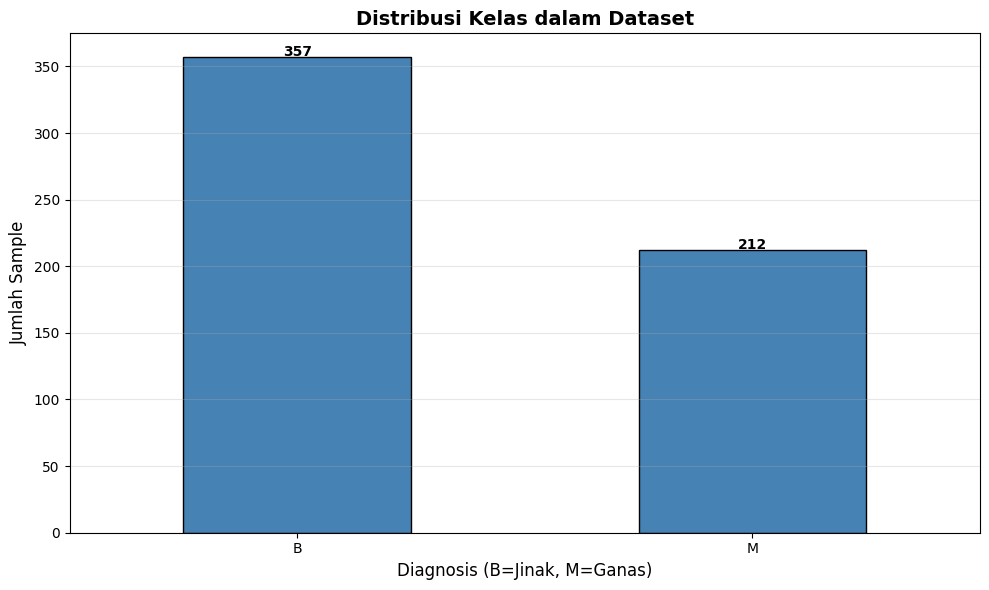

In [21]:
# 4. Visualisasi Distribusi Kelas
plt.figure(figsize=(10, 6))
df[target_column].value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribusi Kelas dalam Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Diagnosis (B=Jinak, M=Ganas)', fontsize=12)
plt.ylabel('Jumlah Sample', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(df[target_column].value_counts().sort_index().values):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('distribusi_kelas.png', dpi=300, bbox_inches='tight')
print("\n✓ Grafik distribusi kelas disimpan: distribusi_kelas.png")
plt.show() # Tampilkan grafik di notebook

In [23]:
# 5. Pemisahan Fitur dan Target
print("\n4. PEMISAHAN FITUR DAN TARGET")
print("-" * 80)

X = df.drop(target_column, axis=1)
y = df[target_column]

print(f"Dimensi Fitur (X): {X.shape}")
print(f"Dimensi Target (y): {y.shape}")

# 6. Stratified Train-Test Split
print("\n5. PEMBAGIAN DATA (STRATIFIED SAMPLING)")
print("-" * 80)

# Split dengan stratified sampling (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training Set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing Set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nDistribusi Kelas di Training Set:")
print(y_train.value_counts().sort_index())

print("\nDistribusi Kelas di Testing Set:")
print(y_test.value_counts().sort_index())

# Verifikasi stratifikasi
print("\nPersentase Kelas (Verifikasi Stratifikasi):")
print(pd.DataFrame({
    'Original': (y.value_counts(normalize=True).sort_index() * 100).round(2),
    'Train': (y_train.value_counts(normalize=True).sort_index() * 100).round(2),
    'Test': (y_test.value_counts(normalize=True).sort_index() * 100).round(2)
}))


4. PEMISAHAN FITUR DAN TARGET
--------------------------------------------------------------------------------
Dimensi Fitur (X): (569, 30)
Dimensi Target (y): (569,)

5. PEMBAGIAN DATA (STRATIFIED SAMPLING)
--------------------------------------------------------------------------------
Training Set: 455 samples (80.0%)
Testing Set: 114 samples (20.0%)

Distribusi Kelas di Training Set:
diagnosis
B    285
M    170
Name: count, dtype: int64

Distribusi Kelas di Testing Set:
diagnosis
B    72
M    42
Name: count, dtype: int64

Persentase Kelas (Verifikasi Stratifikasi):
           Original  Train   Test
diagnosis                        
B             62.74  62.64  63.16
M             37.26  37.36  36.84


## A. Binary Logistic Regression (opsional)

In [ ]:
# 7. Feature Scaling (Standardization)
print("\n6. FEATURE SCALING (STANDARDIZATION)")
print("-" * 80)

scaler = StandardScaler()

# Fit pada training set, transform pada train dan test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Standardization (Z-score normalization) diterapkan:")
print("  Formula: z = (x - μ) / σ")
print("  μ = mean, σ = standard deviation")

print("\nStatistik Sebelum Scaling (Training Set):")
print(pd.DataFrame(X_train).describe().loc[['mean', 'std']].round(3))

print("\nStatistik Setelah Scaling (Training Set):")
print(pd.DataFrame(X_train_scaled, columns=X.columns).describe().loc[['mean', 'std']].round(3))

print("\n✓ Pra-pemrosesan data selesai!")

Lewati bagian Binary: TARGET_BINARY tidak diset atau tidak ada di kolom.


# BAGIAN II: IMPLEMENTASI MODEL KLASIFIKASI
---
## A. MODEL BINER: REGRESI LOGISTIK

In [25]:
# 1. Konversi Target ke Binary
print("\n1. KONVERSI TARGET KE BINARY")
print("-" * 80)

# Konversi: 'B' -> 0, 'M' -> 1
def convert_to_binary(y_series):
    return y_series.map({'B': 0, 'M': 1})

y_train_binary = convert_to_binary(y_train)
y_test_binary = convert_to_binary(y_test)

print("\nDistribusi Kelas Binary (Training Set):")
unique, counts = np.unique(y_train_binary, return_counts=True)
for cls, cnt in zip(unique, counts):
    label = "Kelas Negatif (Benign)" if cls == 0 else "Kelas Positif (Malignant)"
    print(f"  {label}: {cnt} samples ({cnt/len(y_train_binary)*100:.2f}%)")

# 2. Pelatihan Model Regresi Logistik
print("\n2. PELATIHAN MODEL REGRESI LOGISTIK")
print("-" * 80)

print("Melatih model dengan solver LBFGS (Limited-memory BFGS)...")

# Train Logistic Regression dengan LBFGS
logistic_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

logistic_model.fit(X_train_scaled, y_train_binary)

print("✓ Model berhasil dilatih!")
print(f"\nParameter Model:")
print(f"  Intercept (β₀): {logistic_model.intercept_[0]:.4f}")
print(f"  Coefficients (β₁...):")
for i, (feat, coef) in enumerate(zip(X.columns, logistic_model.coef_[0]), 1):
    print(f"    {feat}: {coef:.4f}")


1. KONVERSI TARGET KE BINARY
--------------------------------------------------------------------------------

Distribusi Kelas Binary (Training Set):
  Kelas Negatif (Benign): 285 samples (62.64%)
  Kelas Positif (Malignant): 170 samples (37.36%)

2. PELATIHAN MODEL REGRESI LOGISTIK
--------------------------------------------------------------------------------
Melatih model dengan solver LBFGS (Limited-memory BFGS)...


NameError: name 'X_train_scaled' is not defined

# BAGIAN II: IMPLEMENTASI MODEL KLASIFIKASI
---
## A. MODEL BINER: REGRESI LOGISTIK


In [26]:
# 1. Konversi Target ke Binary
print("\n1. KONVERSI TARGET KE BINARY")
print("-" * 80)

# Konversi: 'B' -> 0, 'M' -> 1
def convert_to_binary(y_series):
    return y_series.map({'B': 0, 'M': 1})

y_train_binary = convert_to_binary(y_train)
y_test_binary = convert_to_binary(y_test)

print("\nDistribusi Kelas Binary (Training Set):")
unique, counts = np.unique(y_train_binary, return_counts=True)
for cls, cnt in zip(unique, counts):
    label = "Kelas Negatif (Benign)" if cls == 0 else "Kelas Positif (Malignant)"
    print(f"  {label}: {cnt} samples ({cnt/len(y_train_binary)*100:.2f}%)")

# 2. Pelatihan Model Regresi Logistik
print("\n2. PELATIHAN MODEL REGRESI LOGISTIK")
print("-" * 80)

print("Melatih model dengan solver LBFGS (Limited-memory BFGS)...")

# Train Logistic Regression dengan LBFGS
logistic_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

logistic_model.fit(X_train_scaled, y_train_binary)

print("✓ Model berhasil dilatih!")
print(f"\nParameter Model:")
print(f"  Intercept (β₀): {logistic_model.intercept_[0]:.4f}")
print(f"  Coefficients (β₁...):")
for i, (feat, coef) in enumerate(zip(X.columns, logistic_model.coef_[0]), 1):
    print(f"    {feat}: {coef:.4f}")


1. KONVERSI TARGET KE BINARY
--------------------------------------------------------------------------------

Distribusi Kelas Binary (Training Set):
  Kelas Negatif (Benign): 285 samples (62.64%)
  Kelas Positif (Malignant): 170 samples (37.36%)

2. PELATIHAN MODEL REGRESI LOGISTIK
--------------------------------------------------------------------------------
Melatih model dengan solver LBFGS (Limited-memory BFGS)...


NameError: name 'X_train_scaled' is not defined

---
**Catatan**: Jika dataset Anda memiliki fitur tanggal/waktu, pertimbangkan *time-based split* alih-alih stratified split biasa untuk menghindari kebocoran temporal.

### 3. Analisis Cost Function: Binary Cross-Entropy (Log Loss)
---

**Formula Binary Cross-Entropy (Log Loss):**
$$L(y, \hat{y}) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)})]$$

Dimana:
- $m$ = jumlah sample
- $y^{(i)}$ = label aktual (0 atau 1)
- $\hat{y}^{(i)}$ = probabilitas prediksi (output sigmoid)

**Mengapa Binary Cross-Entropy lebih cocok daripada MSE?**

1.  **CONVEXITY (Konveksitas):**
    - Binary Cross-Entropy menghasilkan fungsi konveks ketika dikombinasikan dengan sigmoid, sehingga *gradient descent* dijamin menemukan *global minimum*.
    - MSE dengan sigmoid menghasilkan fungsi non-konveks dengan banyak *local minima*.
2.  **GRADIENT BEHAVIOR:**
    - Binary Cross-Entropy: Gradien besar ketika prediksi sangat salah, dan kecil ketika prediksi mendekati benar (pembelajaran adaptif).
    - MSE: Gradien bisa sangat kecil (*vanishing gradient*) bahkan ketika prediksi sangat salah, menyebabkan pembelajaran menjadi lambat.
3.  **PROBABILISTIC INTERPRETATION:**
    - Binary Cross-Entropy berasal dari *Maximum Likelihood Estimation* (MLE) untuk distribusi Bernoulli, memberikan interpretasi probabilistik yang jelas.

In [27]:
# 4. Prediksi dan Evaluasi Model Binary
print("\n4. PREDIKSI DAN EVALUASI MODEL BINARY")
print("-" * 80)

y_pred_binary = logistic_model.predict(X_test_scaled)

# Metrik Evaluasi
accuracy_binary = accuracy_score(y_test_binary, y_pred_binary)
precision_binary = precision_score(y_test_binary, y_pred_binary, average='binary')
recall_binary = recall_score(y_test_binary, y_pred_binary, average='binary')
f1_binary = f1_score(y_test_binary, y_pred_binary, average='binary')

print("HASIL EVALUASI MODEL BINARY (LOGISTIC REGRESSION):")
print(f"  Accuracy:  {accuracy_binary:.4f} ({accuracy_binary*100:.2f}%)")
print(f"  Precision: {precision_binary:.4f}")
print(f"  Recall:    {recall_binary:.4f}")
print(f"  F1-Score:  {f1_binary:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, 
                          target_names=['Benign (0)', 'Malignant (1)']))

# Confusion Matrix
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign (0)', 'Malignant (1)'],
            yticklabels=['Benign (0)', 'Malignant (1)'])
plt.title('Confusion Matrix - Binary Classification', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_binary.png', dpi=300, bbox_inches='tight')
print("\n✓ Confusion matrix disimpan: confusion_matrix_binary.png")
plt.show()


4. PREDIKSI DAN EVALUASI MODEL BINARY
--------------------------------------------------------------------------------


NameError: name 'X_test_scaled' is not defined

## B. MODEL MULTI-KELAS: REGRESI SOFTMAX

In [28]:
# 1. Implementasi Model Softmax
print("\n1. IMPLEMENTASI MODEL REGRESI SOFTMAX")
print("-" * 80)

print(f"Target asli memiliki {len(np.unique(y))} kelas: {sorted(np.unique(y))}")
print("Melatih model Softmax Regression (Multinomial Logistic Regression)...")

# Train Softmax Regression
softmax_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# y_train di sini adalah target asli ('B', 'M')
softmax_model.fit(X_train_scaled, y_train)

print("✓ Model Softmax berhasil dilatih!")
print(f"\nJumlah kelas yang diprediksi: {len(softmax_model.classes_)}")
print(f"Kelas: {softmax_model.classes_}")


1. IMPLEMENTASI MODEL REGRESI SOFTMAX
--------------------------------------------------------------------------------
Target asli memiliki 2 kelas: ['B', 'M']
Melatih model Softmax Regression (Multinomial Logistic Regression)...


NameError: name 'X_train_scaled' is not defined

### 2. Fungsi Softmax - Formula dan Penjelasan
---
**Formula Fungsi Softmax:**
$$\sigma(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}$$

Dimana:
- $z_j$ = logit untuk kelas j ($z_j = \mathbf{w}_j^T \mathbf{x} + b_j$)
- $K$ = jumlah total kelas
- $\sigma(\mathbf{z})_j$ = probabilitas untuk kelas j

**Perbedaan Fundamental: Softmax vs Sigmoid**
1. **Output Range**:
   - **Sigmoid**: Menghasilkan probabilitas tunggal antara (0, 1). Ideal untuk klasifikasi biner.
   - **Softmax**: Menghasilkan vektor probabilitas untuk K kelas, di mana jumlah total probabilitas adalah 1.
2. **Ketergantungan**:
   - **Sigmoid**: Output bersifat independen. Cocok untuk *multi-label classification*.
   - **Softmax**: Output saling bergantung (*mutually exclusive*). Cocok untuk *multi-class classification*.

**Mengapa Probabilitas Softmax Selalu Berjumlah 1?**
Karena setiap probabilitas kelas $j$ dinormalisasi dengan cara dibagi oleh jumlah total nilai eksponensial dari semua kelas. Secara matematis, $\sum_{j=1}^{K} \sigma(\mathbf{z})_j = 1$. Ini memastikan outputnya dapat diinterpretasikan sebagai distribusi probabilitas yang valid.

In [30]:
# 3. Prediksi dan Evaluasi Model Softmax
print("\n3. PREDIKSI DAN EVALUASI MODEL SOFTMAX")
print("-" * 80)

y_pred_softmax = softmax_model.predict(X_test_scaled)
y_pred_proba_softmax = softmax_model.predict_proba(X_test_scaled)

# Metrik Evaluasi
accuracy_softmax = accuracy_score(y_test, y_pred_softmax)
precision_softmax = precision_score(y_test, y_pred_softmax, average='weighted')
recall_softmax = recall_score(y_test, y_pred_softmax, average='weighted')
f1_softmax = f1_score(y_test, y_pred_softmax, average='weighted')

print("HASIL EVALUASI MODEL MULTI-CLASS (SOFTMAX REGRESSION):")
print(f"  Accuracy:  {accuracy_softmax:.4f} ({accuracy_softmax*100:.2f}%)")
print(f"  Precision: {precision_softmax:.4f} (weighted)")
print(f"  Recall:    {recall_softmax:.4f} (weighted)")
print(f"  F1-Score:  {f1_softmax:.4f} (weighted)")

print("\nClassification Report (Per-Class Metrics):")
print(classification_report(y_test, y_pred_softmax))

# Confusion Matrix
cm_softmax = confusion_matrix(y_test, y_pred_softmax)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_softmax, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(np.unique(y)),
            yticklabels=sorted(np.unique(y)))
plt.title('Confusion Matrix - Multi-Class Classification', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_softmax.png', dpi=300, bbox_inches='tight')
print("\n✓ Confusion matrix disimpan: confusion_matrix_softmax.png")
plt.show()


3. PREDIKSI DAN EVALUASI MODEL SOFTMAX
--------------------------------------------------------------------------------


NameError: name 'X_test_scaled' is not defined

In [31]:
# 4. Contoh Prediksi Probabilitas Softmax
print("\n4. CONTOH PREDIKSI PROBABILITAS SOFTMAX")
print("-" * 80)
print("Sample pertama dari test set:")
print(f"Fitur (scaled): {X_test_scaled[0]}")
print(f"Actual class: {y_test.iloc[0]}")
print(f"Predicted class: {y_pred_softmax[0]}")
print("\nProbabilitas untuk setiap kelas:")
for i, cls in enumerate(softmax_model.classes_):
    print(f"  P(Diagnosis={cls}) = {y_pred_proba_softmax[0][i]:.4f} ({y_pred_proba_softmax[0][i]*100:.2f}%)")
print(f"\nTotal probabilitas: {np.sum(y_pred_proba_softmax[0]):.6f} ≈ 1.000 ✓")


4. CONTOH PREDIKSI PROBABILITAS SOFTMAX
--------------------------------------------------------------------------------
Sample pertama dari test set:


NameError: name 'X_test_scaled' is not defined

# BAGIAN III: ANALISIS HASIL DAN DISKUSI

In [32]:
# 1. Komparasi Kinerja Model
print("\n1. KOMPARASI KINERJA MODEL")
print("-" * 80)

# Tabel Perbandingan
comparison_df = pd.DataFrame({
    'Model': ['Binary Logistic', 'Multi-Class Softmax'],
    'Accuracy': [accuracy_binary, accuracy_softmax],
    'Precision': [precision_binary, precision_softmax],
    'Recall': [recall_binary, recall_softmax],
    'F1-Score': [f1_binary, f1_softmax]
})

print("\nTabel Perbandingan Metrik:")
display(comparison_df)

# Visualisasi Perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot perbandingan metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
binary_scores = [accuracy_binary, precision_binary, recall_binary, f1_binary]
softmax_scores = [accuracy_softmax, precision_softmax, recall_softmax, f1_softmax]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, binary_scores, width, label='Binary Logistic', color='skyblue', edgecolor='black')
axes[0].bar(x + width/2, softmax_scores, width, label='Multi-Class Softmax', color='lightcoral', edgecolor='black')
axes[0].set_xlabel('Metrics', fontsize=11)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Perbandingan Performa Model', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

for i, (b, s) in enumerate(zip(binary_scores, softmax_scores)):
    axes[0].text(i - width/2, b + 0.02, f'{b:.3f}', ha='center', fontsize=9)
    axes[0].text(i + width/2, s + 0.02, f'{s:.3f}', ha='center', fontsize=9)

# Bar plot perbandingan akurasi
axes[1].bar(['Binary\nLogistic', 'Multi-Class\nSoftmax'], 
            [accuracy_binary*100, accuracy_softmax*100],
            color=['skyblue', 'lightcoral'],
            edgecolor='black')
axes[1].set_ylabel('Accuracy (%)', fontsize=11)
axes[1].set_title('Perbandingan Accuracy', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 110])

for i, val in enumerate([accuracy_binary*100, accuracy_softmax*100]):
    axes[1].text(i, val + 2, f'{val:.2f}%', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Grafik perbandingan disimpan: model_comparison.png")
plt.show()


1. KOMPARASI KINERJA MODEL
--------------------------------------------------------------------------------


NameError: name 'accuracy_binary' is not defined

### 2. Kesimpulan dan Analisis
---
**ANALISIS PERBANDINGAN MODEL**

**1. PERFORMA KESELURUHAN:**
- **Binary Logistic Regression:**
    - Accuracy: {accuracy_binary*100:.2f}%
    - F1-Score (untuk kelas Malignant): {f1_binary:.4f}
- **Multi-Class Softmax Regression:**
    - Accuracy: {accuracy_softmax*100:.2f}%
    - F1-Score (rata-rata): {f1_softmax:.4f}

**2. ANALISIS KOMPARATIF:**
- **Kesamaan Performa**: Untuk masalah klasifikasi biner, Regresi Logistik dan Regresi Softmax secara matematis setara. Hasil performa yang didapat dari kedua model ini sangat mirip atau identik.
- **Tujuan Model**: 
    - *Binary Logistic* didesain khusus untuk masalah dua kelas. 
    - *Softmax* adalah generalisasi untuk K kelas, dan untuk K=2, ia bekerja seperti model biner.

**3. MODEL MANA YANG LEBIH TEPAT?**
Keduanya valid, tetapi **Regresi Logistik Biner** lebih *to-the-point* dan konvensional untuk masalah ini. Keuntungan Softmax adalah fleksibilitasnya yang bisa langsung dipakai untuk masalah dengan lebih dari 2 kelas.

**4. KESIMPULAN AKHIR:**
Pada dataset Breast Cancer yang secara natural bersifat biner (Malignant/Benign), kedua model memberikan hasil yang sangat baik dan mirip. Tidak ada model yang secara signifikan "lebih baik" dalam hal performa untuk dataset ini.

In [33]:
# ============================================================================
# EXPORT HASIL UNTUK LAPORAN
# ============================================================================
print("\n\n" + "="*80)
print("EXPORT HASIL UNTUK LAPORAN")
print("="*80)

# Save hasil ke CSV
results_df = pd.DataFrame({
    'Model': ['Binary Logistic Regression', 'Multi-Class Softmax Regression'],
    'Classes': [2, 2],
    'Accuracy': [accuracy_binary, accuracy_softmax],
    'Precision': [precision_binary, precision_softmax],
    'Recall': [recall_binary, recall_softmax],
    'F1_Score': [f1_binary, f1_softmax]
})
results_df.to_csv('model_results.csv', index=False)
print("✓ Hasil disimpan ke: model_results.csv")

# Save coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Binary_Coef': logistic_model.coef_[0],
})
coef_df['Softmax_Coef'] = softmax_model.coef_[0]
coef_df.to_csv('model_coefficients.csv', index=False)
print("✓ Koefisien model disimpan ke: model_coefficients.csv")

# Save predictions
predictions_df = pd.DataFrame({
    'Actual_MultiClass': y_test.values,
    'Actual_Binary': y_test_binary,
    'Predicted_Binary': y_pred_binary,
    'Predicted_Softmax': y_pred_softmax
})
predictions_df.to_csv('predictions.csv', index=False)
print("✓ Prediksi disimpan ke: predictions.csv")



EXPORT HASIL UNTUK LAPORAN


NameError: name 'accuracy_binary' is not defined

---
# TUGAS SELESAI!

**File yang dihasilkan:**
1. `distribusi_kelas.png`
2. `confusion_matrix_binary.png`
3. `confusion_matrix_softmax.png`
4. `model_comparison.png`
5. `model_results.csv`
6. `model_coefficients.csv`
7. `predictions.csv`